# Attention Layer

## Import Lib

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.xpu import device
from torchvision import models
from torchvision import datasets
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, f1_score

import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
# Set a fixed seed value
seed_value = 40

# Set the random seed for Python's built-in random module
random.seed(seed_value)

# Set the random seed for NumPy
np.random.seed(seed_value)

# Set the random seed for PyTorch
torch.manual_seed(seed_value)

# If using CUDA, set the seed for GPU as well (if applicable)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed_value)


In [3]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

## Data Preparation

In [4]:
import numpy as np
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor

class DatasetGenerator:
    def __init__(self, mnist_data, n_bags=1000, min_instances=3, max_instances=5):
        self.mnist_data = mnist_data
        self.n_bags = n_bags
        self.min_instances = min_instances
        self.max_instances = max_instances
        self.empty_image = torch.zeros(1, 28, 28)  # Create an empty image tensor (1x28x28)

    def create_bags(self):
        bags = []
        labels = []
        
        for _ in range(self.n_bags):
            # Randomly choose a number of instances for the bag
            n_instances = np.random.randint(self.min_instances, self.max_instances + 1)
            
            # Randomly select instances from the dataset
            bag_indices = np.random.choice(len(self.mnist_data), n_instances, replace=False)
            bag_images = [self.mnist_data[i][0] for i in bag_indices]
            
            # Determine the label: 1 if any instance is '9', else 0
            label = 1 if any(self.mnist_data[i][1] == 9 for i in bag_indices) else 0
            
            # Convert images to tensors and pad to ensure exactly 7 instances
            bag_images_tensors = [ToTensor()(img) for img in bag_images]
            while len(bag_images_tensors) < 7:
                bag_images_tensors.append(self.empty_image)  # Pad with empty image
            
            bags.append(torch.stack(bag_images_tensors))
            labels.append(label)

        return bags, labels

class TrainDatasetGenerator(DatasetGenerator):
    def __init__(self, mnist_data, n_bags=1000):
        super().__init__(mnist_data, n_bags)

class TestDatasetGenerator(DatasetGenerator):
    def __init__(self, mnist_data, n_bags=500):  # Example: fewer bags for testing
        super().__init__(mnist_data, n_bags)

In [5]:
# Load MNIST dataset
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True)

# Create training dataset generator and generate bags
train_generator = TrainDatasetGenerator(mnist_dataset)
train_bags, train_labels = train_generator.create_bags()
train_loader = DataLoader(list(zip(train_bags, train_labels)), batch_size=32, shuffle=True)

# Create test dataset generator and generate bags
test_generator = TestDatasetGenerator(mnist_dataset)
test_bags, test_labels = test_generator.create_bags()
# Create DataLoader for testing
test_loader = DataLoader(list(zip(test_bags, test_labels)), batch_size=16, shuffle=True)

## Attention Layer

In [6]:
# class SelfAttention(nn.Module):
#     def __init__(self, input_dim):
#         super(SelfAttention, self).__init__()
#         self.input_dim = input_dim
#         self.query = nn.Linear(input_dim, input_dim)
#         self.key = nn.Linear(input_dim, input_dim)
#         self.value = nn.Linear(input_dim, input_dim)
#         self.softmax = nn.Softmax(dim=2)
# 
#     def forward(self, x):  # x.shape (batch_size, seq_length, input_dim)
#         queries = self.query(x)
#         keys = self.key(x)
#         values = self.value(x)
# 
#         score = torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim ** 0.5)
#         attention = self.softmax(score)
#         weighted = torch.bmm(attention, values)
#         return weighted, attention

class AttentionLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim=512):
        super(AttentionLayer, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            # nn.Tanh(),
            # nn.ReLU(),
            nn.PReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        # x shape: (batch_size, num_instances, feature_dim)
        attention_weights = self.attention(x)
        weights = F.softmax(attention_weights, dim=1)

        return (x * weights).sum(dim=1), weights.squeeze(-1)

## MIL-CNN Model

In [7]:
class MILResNet18(nn.Module):
    def __init__(self):
        super(MILResNet18, self).__init__()
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        # Modify the first convolutional layer to accept grayscale images
        # Change in_channels from 3 to 1
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.resnet.fc = nn.Identity()  # Remove the final classification layer
        self.attention = AttentionLayer(input_dim=512)  # Assuming output dim from ResNet is 512
        self.classifier = nn.Linear(512, 1)  # Binary classification
        self.dropout = nn.Dropout(0.4)
      
    def forward(self, bags):
        # bags.shape: (batch_size, num_instances, channels, height, width)
        batch_size, num_instances = bags.size(0), bags.size(1)
        
        # Flatten to (batch_size * num_instances, channels, height, width)
        bags_flattened = bags.view(-1, *bags.shape[2:])
        
        # Get features from ResNet
        features = self.resnet(bags_flattened)  # Shape: (batch_size * num_instances, 512)

        # Reshape back to (batch_size, num_instances, 512)
        features = features.view(batch_size, num_instances, -1)

        # Apply attention mechanism
        attended_features, attended_weights = self.attention(features)

        # Aggregate features (e.g., mean pooling)
        # aggregated_features = attended_features.mean(dim=1)  # Shape: (batch_size, 512)
        
        # dropped_features = self.dropout(aggregated_features)
        dropped_features = self.dropout(attended_features)
        # Classify bag
        outputs = torch.sigmoid(self.classifier(dropped_features))
        
        return outputs, attended_weights

## Training Process

In [8]:
def train(model, dataloader, epochs=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCELoss()
    
    model.train()
    
    for epoch in range(epochs):
        all_labels = []
        all_outputs = []
        total_loss = 0
        
        for batch_images, batch_labels in dataloader:
            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)
            optimizer.zero_grad()
            
            # Forward pass
            outputs, _ = model(batch_images.float())
            loss = criterion(outputs.squeeze(), batch_labels.float())
            total_loss += loss.item()
            
            # Backward pass
            loss.backward()
            optimizer.step()

            # Collect outputs and labels for metrics calculation
            all_labels.extend(batch_labels.cpu().numpy())
            all_outputs.extend((outputs.squeeze().cpu().detach().numpy() > 0.5).astype(int))  # Binarize outputs
            
        # Calculate metrics
        avg_loss = total_loss / len(dataloader)
        accuracy = accuracy_score(all_labels, all_outputs)
        precision = precision_score(all_labels, all_outputs)
        f1 = f1_score(all_labels, all_outputs)

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, '
              f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, F1 Score: {f1:.4f}')

### Testing Function
# def test(model, dataloader):
#     model.eval()
#     all_labels = []
#     all_outputs = []
#     
#     with torch.no_grad():
#         for batch_images, batch_labels in dataloader:
#             batch_images = batch_images.to(device)
#             batch_labels = batch_labels.to(device)
# 
#             # Forward pass
#             outputs, attended_weights = model(batch_images.float())
#             
#             # Collect outputs and labels for metrics calculation
#             all_labels.extend(batch_labels.cpu().numpy())
#             all_outputs.extend((outputs.squeeze().cpu().detach().numpy() > 0.5).astype(int))  # Binarize outputs
# 
#     # Calculate metrics
#     accuracy = accuracy_score(all_labels, all_outputs)
#     precision = precision_score(all_labels, all_outputs)
#     f1 = f1_score(all_labels, all_outputs)
# 
#     print(f'Test Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, F1 Score: {f1:.4f}')


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MILResNet18()
model.to(device)

train(model, train_loader)

Epoch [1/10], Loss: 0.4885, Accuracy: 0.7910, Precision: 0.7188, F1 Score: 0.6064
Epoch [2/10], Loss: 0.2508, Accuracy: 0.9070, Precision: 0.8794, F1 Score: 0.8421
Epoch [3/10], Loss: 0.1793, Accuracy: 0.9370, Precision: 0.9296, F1 Score: 0.8934
Epoch [4/10], Loss: 0.1204, Accuracy: 0.9700, Precision: 0.9695, F1 Score: 0.9502
Epoch [5/10], Loss: 0.1415, Accuracy: 0.9500, Precision: 0.9356, F1 Score: 0.9169
Epoch [6/10], Loss: 0.0868, Accuracy: 0.9660, Precision: 0.9446, F1 Score: 0.9446
Epoch [7/10], Loss: 0.0647, Accuracy: 0.9780, Precision: 0.9672, F1 Score: 0.9641
Epoch [8/10], Loss: 0.0471, Accuracy: 0.9830, Precision: 0.9708, F1 Score: 0.9724
Epoch [9/10], Loss: 0.0578, Accuracy: 0.9770, Precision: 0.9641, F1 Score: 0.9625
Epoch [10/10], Loss: 0.0429, Accuracy: 0.9890, Precision: 0.9774, F1 Score: 0.9822


## Testing Process

Test Accuracy: 0.9660, Precision: 0.9551, F1 Score: 0.9524


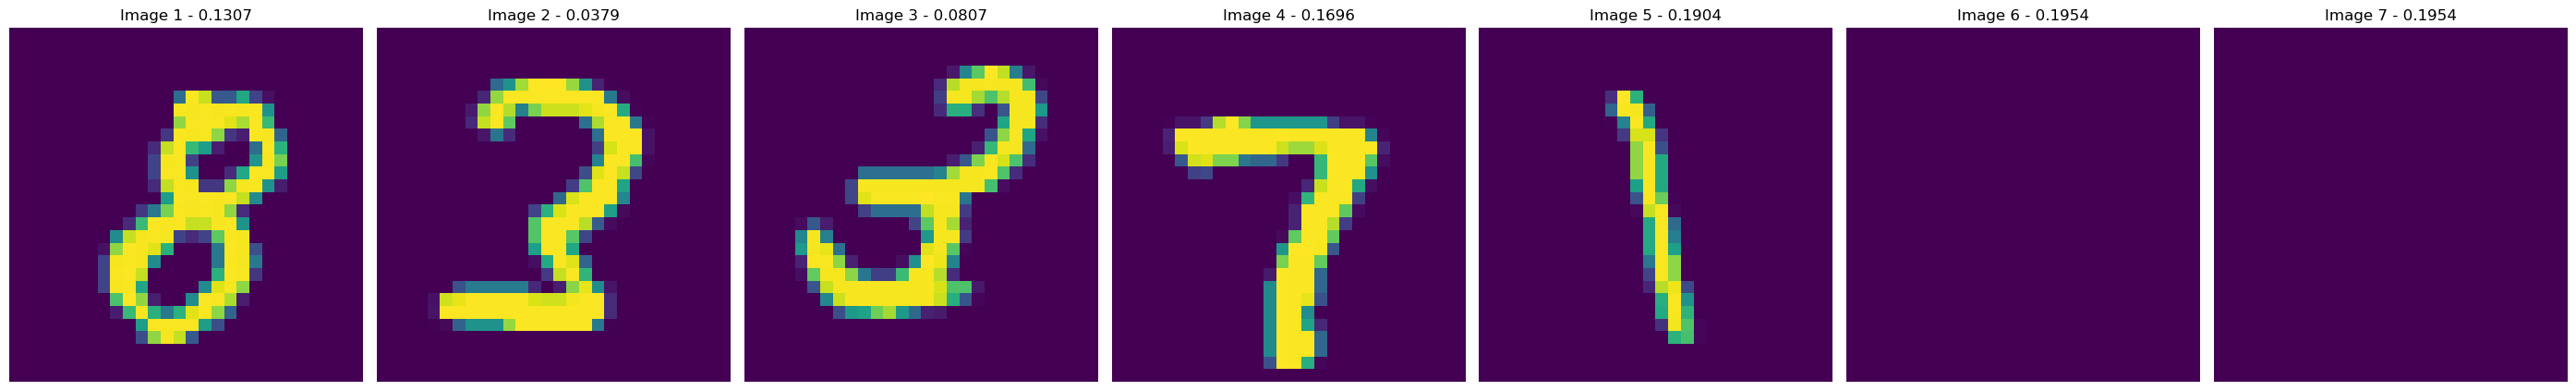

In [9]:
def test(model, dataloader):
    model.eval()
    all_labels = []
    all_outputs = []
    all_attended_weights = []  # Store attended weights for visualization
    images_to_plot = []  # Store images with label = 1
    weights_to_plot = []  # Store attended weights for images with label = 1

    with torch.no_grad():
        for batch_images, batch_labels in dataloader:
            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)

            # Forward pass
            outputs, attended_weights = model(batch_images.float())

            # Collect outputs and labels for metrics calculation
            all_labels.extend(batch_labels.cpu().numpy())
            all_outputs.extend((outputs.squeeze().cpu().detach().numpy() > 0.5).astype(int))  # Binarize outputs

            # Check for images with label = 1
            for i in range(len(batch_labels)):
                if batch_labels[i] == 0:
                    images_to_plot.append(batch_images[i].cpu().numpy())
                    weights_to_plot.append(attended_weights[i].squeeze().cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_outputs)
    precision = precision_score(all_labels, all_outputs)
    f1 = f1_score(all_labels, all_outputs)

    print(f'Test Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, F1 Score: {f1:.4f}')

    # Plotting attended weights for images with label = 1
    if images_to_plot:  # Check if there are any images to plot
        plot_attended_weights(np.array(images_to_plot), np.array(weights_to_plot))

def plot_attended_weights(images, attended_weights):
    """
    Plots the original images and their corresponding attended weights in a single figure.

    Args:
        images (numpy array): A batch of input image arrays.
        attended_weights (numpy array): The attended weights corresponding to the images.
    """
    images = images[0]
    attended_weights = attended_weights[0]
    num_images = images.shape[0]  # Number of images to plot

    # Create subplots
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 4, 8))

    for i in range(num_images):
        # Display the input image
        axes[i].imshow(images[i].transpose(1, 2, 0))  # Change from CHW to HWC format
        axes[i].set_title(f'Image {i + 1} - {attended_weights[i]:.4f}')
        axes[i].axis('off')
        
        # Plot attention weights as a bar chart
        # axes[1, i].bar(range(attended_weights.shape[1]), attended_weights[i], color='orange', alpha=0.7)
        # axes[1, i].set_ylim(0, 1)  # Assuming weights are normalized between 0 and 1
        # axes[1, i].set_ylabel('Attention Weight')
        # axes[1, i].set_xlabel('Feature Index')

    plt.tight_layout()
    plt.show()
    
# Call the test function with your model and test loader
test(model, test_loader)

## References:
[1] https://medium.com/@wangdk93/implement-self-attention-and-cross-attention-in-pytorch-1f1a366c9d4b